In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import glob
from tqdm import tqdm

<img src='PCygni_Sadr_spectra.png' width="1000">


In [3]:
def load_fits(img):
    '''
    loads fits data from HARPS spectrograph and outputs the header and data
    Parameters
    ----------
    img: string
        filename including path to a fits file
    Output
    ------
    data: np.ndarray[np.float64]
        NxM array of intensities
    header: 
        header of fits file
    '''
    hdu = fits.open(img)
    header = hdu[0].header
    data = (hdu[0].data).astype(np.float64)
    
    return data, header

def load_data_cube(path):
    '''
    searches for all data fits files in a directory and loads them into a numpy 3D data cube
    Parameters
    ----------
    path: string
        path to directory with fits files, will search for all files of specified extension
    Output
    ------
    data_cube: np.ndarray[np.float64]
        ixMxN array where each i index corresponds to a different fits data file
        each data file is transposed into a MxN matrix
    header_list: list[astropy.io.fits.Header]
        list of each corresponding fits header file
    Example
    -------
    search for all fits files starting with 'HARPS' with .fits extention
        path = 'Spectro-Module/raw/HARPS.*.fits'
    '''
    # searches for all files within a directory
    fits_files = sorted(glob.glob(path))
    # allocate ixMxN data cube array
    i = len(fits_files)
    data, header = load_fits(fits_files[0])
    data_cube = np.zeros((i, data.shape[0], data.shape[1]))
    # save first file to data arrays
    data_cube[0,:,:] = data
    header_list = [header]
    # loop through each array in data list and store in data cube
    for i in tqdm(range(1, len(fits_files))):
        data, header = load_fits(fits_files[i])
        data_cube[i,:,:] = data
        header_list.append(header)
        
    return data_cube, header_list

In [4]:
# load data files
pcygni_cube, pcygni_header = load_data_cube('PCygni_Sadr_Data/Cyg*.FIT')
sadr_cube, sadr_header = load_data_cube('PCygni_Sadr_Data/Sadir*.FIT')
sky_cube, sky_header = load_data_cube('PCygni_Sadr_Data/Sky*.FIT')
arc_cube, arc_header = load_data_cube('PCygni_Sadr_Data/Merc*.FIT')
# read synthetic calibration spectrum
cal_wave, cal_flux, _ = np.loadtxt('PCygni_Sadr_Data/f8i.dat', unpack = True, skiprows = 1, usecols = (0,1,2))
# convert to nm from Angstrom
cal_wave = cal_wave/10

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 326.81it/s]


In [6]:
def calibrate_frames(data_cube):
    '''
    reduces input files by stacking, bias subtracting, and converting flux to photo-electron units
    Parameter
    ---------
    data_cube: np.ndarray[np.float64]
        ixMxN data cube of images to be processed
    Outputs
    -------
    flux: np.ndarray[np.float64]
        MxN stacked array of all i images   
    errors: np.ndarray[np.float64]
        MxN array corresponding to the error for each pixel 
    '''
    # sum the ixMxN array along the i axis into a MxN array
    flux = np.sum(data_cube, axis = 0)

    # compute error
    # number of electrons per pixel
    readout_noise = 5
    # photon shot noise
    mask = flux > 0.0
    shot_noise = np.sqrt(flux[mask])
    # total error
    errors = np.sqrt(readout_noise**2 + shot_noise**2)
    
    return flux, errors

# sum frames
pcygni_flux, pcygni_errors = calibrate_frames(pcygni_cube)
sky_flat = np.median(sky_cube, axis = 0)
# subtract sky
pcygni_flux = pcygni_flux - sky_flat
sadr_flux, pcygni_errors = calibrate_frames(sadr_cube)
arc_flux, arc_errors = calibrate_frames(arc_cube)

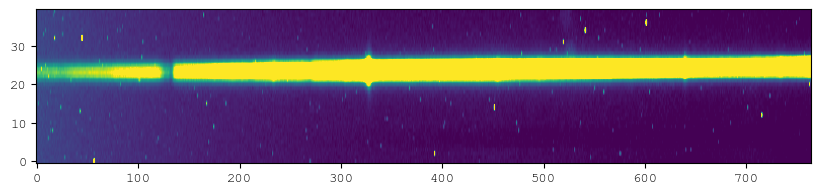

In [9]:
# display P Cygni summed spectral order
data = pcygni_flux[110:150,:]
plt.figure(figsize = (10,2))
plt.rcParams['font.family'] = 'courier new'
vmin = np.percentile(data, 10)
vmax = np.percentile(data, 90)
plt.imshow(data, vmin = vmin, vmax = vmax, origin = 'lower', aspect = 'auto')
plt.show()

In [10]:
def compute_spectral_order_model(data, offset = 0):
    '''
    computes a 3rd order polynomial modeling the curvature of a spectral order
    Parameter
    ---------
    data: np.ndarray[np.float64]
        mxn array representing a spectral order from a slice of a MxN fits data array
    offset: int
        offset to shift the y-indices of the maximum values back to their original scale
        offset is equal to the lower bound of the array slice
        this is necessary as the input slice starts from 0, but the original data may have 
        a different starting index
    Output
    ------
    x_pixels: np.ndarray[np.int64]
        (n,) shaped array representing the range of x pixel values in the fits image 
    max_flux: np.ndarray[np.int64]
        (n,) shaped array representing the indeces of the maximum y values along the x axis
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    Example
    -------
        order_slice = data_cube[0][700:800, :]
        x_pixels, model = compute_spectral_order_model(order_slice, offset = 700)
        plt.plot(x_pixels, model(x_pixels))
    '''
    # for each x pixel in the input array, find the index of the max y value
    max_flux = np.argmax(data, axis = 0) + int(offset)
    # create array with range ϵ[0, max_flux.shape[0])
    x_pixels = np.arange(max_flux.shape[0])
    # compute coefficients of 3rd order polynomial
    coefficients = np.polyfit(x_pixels, max_flux, 3)
    model = np.poly1d(coefficients)
    
    return x_pixels, max_flux, model

# model spectrum order for precise extraction
x_pixels, pc_max_flux, pcygni_model = compute_spectral_order_model(pcygni_flux[110:150,:], offset = 110)
x_pixels, sadr_max_flux, sadr_model = compute_spectral_order_model(sadr_flux[120:160,:], offset = 120)
x_pixels, arc_max_flux, arc_model = compute_spectral_order_model(arc_flux[90:140], offset = 90)

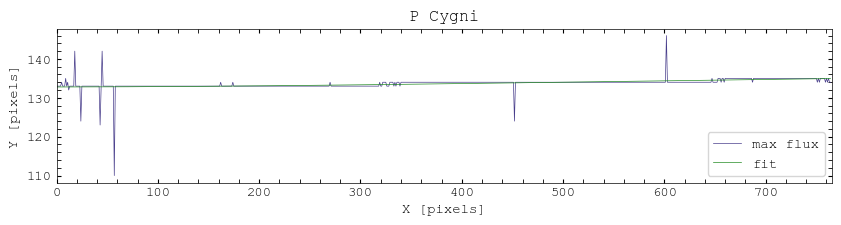

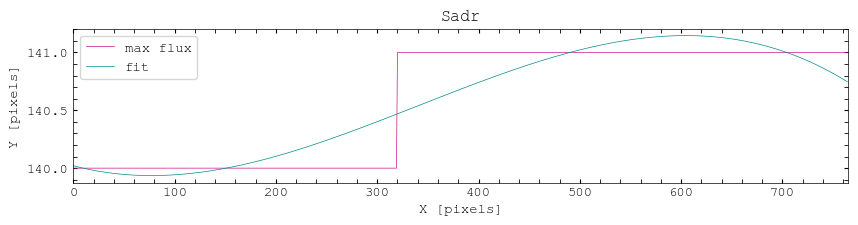

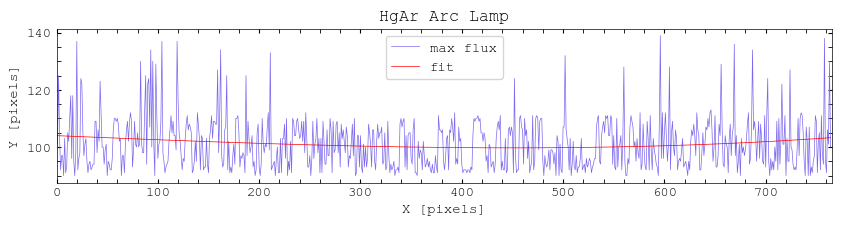

In [11]:
plt.figure(figsize = (10, 2))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['axes.linewidth'] = 0.5
plt.minorticks_on()
plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
plt.plot(x_pixels, pc_max_flux, c = 'darkslateblue', lw = 0.5, label = 'max flux')
plt.plot(x_pixels, pcygni_model(x_pixels), c = 'forestgreen', lw = 0.5, label = 'fit')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.xlim(0,765)
plt.title('P Cygni')
plt.legend()
plt.show()

plt.figure(figsize = (10, 2))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['axes.linewidth'] = 0.5
plt.minorticks_on()
plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
plt.plot(x_pixels, sadr_max_flux, c = 'mediumvioletred', lw = 0.5, label = 'max flux')
plt.plot(x_pixels, sadr_model(x_pixels), c = 'darkcyan', lw = 0.5, label = 'fit')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.xlim(0,765)
plt.title('Sadr')
plt.legend()
plt.show()

plt.figure(figsize = (10, 2))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['axes.linewidth'] = 0.5
plt.minorticks_on()
plt.tick_params(axis = 'both', length = 3, direction = 'in', which = 'both', right = True, top = True)
plt.plot(x_pixels, arc_max_flux, c = 'mediumslateblue', lw = 0.5, label = 'max flux')
plt.plot(x_pixels, arc_model(x_pixels), c = 'red', lw = 0.5, label = 'fit')
plt.xlabel('X [pixels]')
plt.ylabel('Y [pixels]')
plt.xlim(0,765)
plt.title('HgAr Arc Lamp')
plt.legend()
plt.show()

In [12]:
def extract_spectral_continuum(data, x_pixels, model, window_range = 7):
    '''
    extracts the continuum flux of a spectral order by summing flux values 
    within a ±7 pixel window centered around the peak of each x-pixel
    Parameter
    ---------
    data: np.ndarray[np.float64]
        MxN stacked continuum image
    x_pixels: np.ndarray[np.int64]
        (n,) shaped array representing the range of x pixel values in the fits image 
    model: np.poly1d
        callable 3rd order function modeling the curvature of the spectral order
    window_range = int
        specifies the ± bounds for the window along the y axis to sum
    Output
    ------
    extracted_continuum: np.ndarray[np.float64]
        (N,) shaped array representing the normalized extracted spectral order at every x_pixel value
        this is the raw extracted spectrum flux before wavelength calibration        
    '''
    window_size = int(window_range*2+1)
    # 15xN data array to store the flux values in a ±7 pixel window centered at the peak y index of each x-pixel
    continuum_array = np.zeros((window_size, data.shape[1]))
    # 15x1 array of values in range ϵ[-7, 7] to broadcast a ±7 pixel window across all x pixels
    offset_range = np.arange(-window_range, int(window_range+1))[:, np.newaxis]
    # compute indeces of the maximum flux values for each x pixel, rounded to the nearest integer
    max_flux_idx = np.round(model(x_pixels)).astype(int)
    # compute a 15xN array of y-indices, where each row represents an offset from the peak flux position
    flux_window_idx = max_flux_idx + offset_range
    # extract the spectral continuum by indexing the data array using computed y-indices and x-pixels
    continuum_array = data[flux_window_idx, x_pixels]
    # sum the flux values along the y axis into a (N,) shaped array
    extracted_continuum = np.sum(continuum_array, axis = 0)
    # normalize the extracted continuum
    extracted_continuum = extracted_continuum / np.max(extracted_continuum)
    
    return extracted_continuum[::-1]

pcygni_extracted = extract_spectral_continuum(pcygni_flux, x_pixels, pcygni_model)
sadr_extracted = extract_spectral_continuum(sadr_flux, x_pixels, sadr_model)
arc_extracted = extract_spectral_continuum(arc_flux, x_pixels, arc_model, window_range = 25)

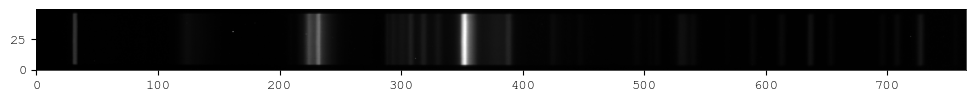

In [13]:
data = arc_flux[115:165,:][:, ::-1]
plt.figure(figsize = (12,4))
plt.rcParams['font.family'] = 'courier new'
plt.imshow(data, origin = 'lower', cmap = 'gray')
plt.xlim(0,765)
plt.show()

In [14]:
# location of emission lines on image in pixels
pixels = np.array([31.4, 233, 510, 590, 613.5, 636.1, 654.1, 696, 708, 727.0])
# corresponding emission lines in nanometers
HgAr_lines = np.array([435.833, 546.074, 706.772, 738.393, 750.387, 763.5106, 772.376, 794.818, 801.479, 811.5311]) 

polyfit = np.polyfit(pixels, HgAr_lines, 1)
pixel_to_wavelgth = np.poly1d(polyfit)
print('linear least sqaures fit: {}'.format(pixel_to_wavelgth))

# calibrate wavelengths
z = np.arange(0,765,1)
wavelength = pixel_to_wavelgth(z)

linear least sqaures fit:  
0.5389 x + 421.2


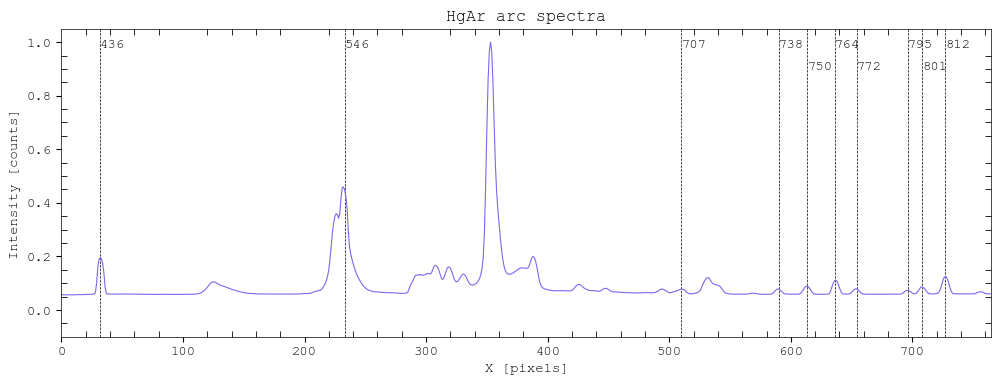

In [15]:
fig, ax = plt.subplots(figsize = (12, 4))

plt.rcParams['font.family'] = 'courier new'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = 0.6
displacement = [0.98,0.98,0.98,0.98,0.9,0.98,0.9,0.98,0.9,0.98]
for i, (pixel, wave) in enumerate(zip(pixels, HgAr_lines)):
    plt.vlines(pixel, -0.1, 1.05, lw = 0.5, color = 'k', ls = '--')
    plt.text(pixel, displacement[i], '{}'.format(int(np.round(wave))))

plt.plot(arc_extracted, c = 'mediumslateblue', lw = 0.8)
plt.xlim(0, 765)
plt.ylim(-0.1, 1.05)
plt.title('HgAr arc spectra')
plt.xlabel('X [pixels]')
plt.ylabel('Intensity [counts]')
plt.show()

In [16]:
def plot_spectra(wavelength, flux, label, color = 'darkslateblue'):
    fig, ax = plt.subplots(figsize = (13, 3))
    plt.rcParams['font.family'] = 'courier new'
    plt.rcParams['mathtext.default'] = 'regular'
    ax.minorticks_on()
    ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
    plt.rcParams['axes.linewidth'] = 0.6
    
    plt.plot(wavelength, flux, lw = 0.8, c = color, label = label)
    padding = 0.05 * (np.max(flux) - np.min(flux))
    ymin = np.min(flux) - padding
    ymax = np.max(flux) + padding
    
    plt.vlines(486.13, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(487.13, ymax-2*padding, r'$H\beta$')
    plt.vlines(495.8, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(496.8, ymax-2*padding, 'Fe')
    plt.vlines(587.56, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(588.56, ymax-2*padding, r'$He I$')
    plt.vlines(656.28, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(657.28, ymax-2*padding, r'$H\alpha$')
    plt.vlines(686.7, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
    plt.text(687.7, ymax-2*padding, r'$O2_{\oplus}$')

 

    plt.xlim(wavelength[0], wavelength[-1])
    plt.ylim(ymin, ymax)
    plt.xlabel('$\lambda [nm]$', size = 13)
    plt.ylabel('Flux [counts]', size = 13)
    plt.legend()
    plt.show()

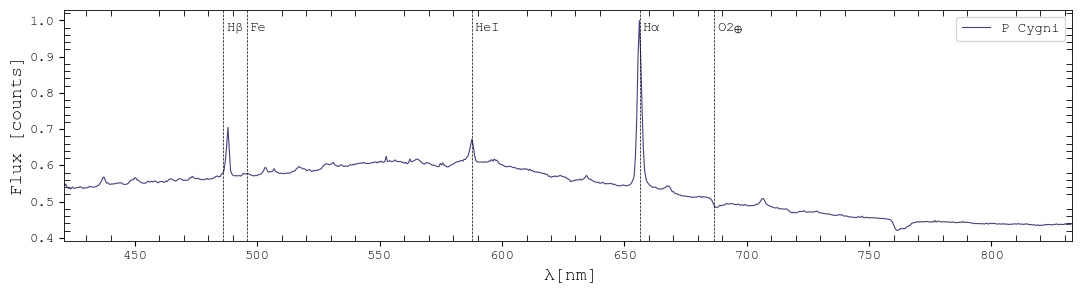

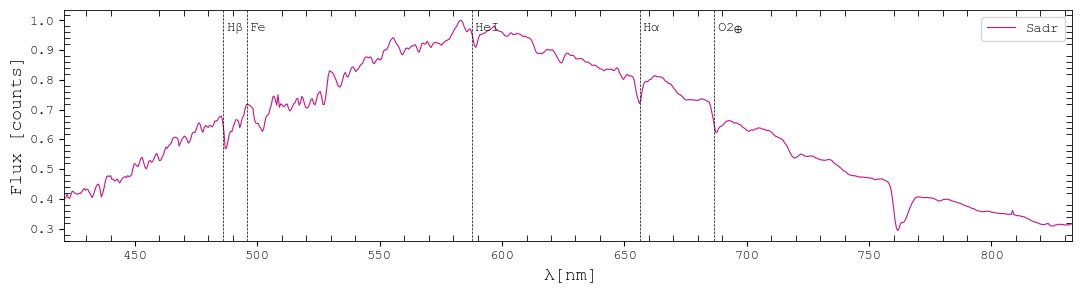

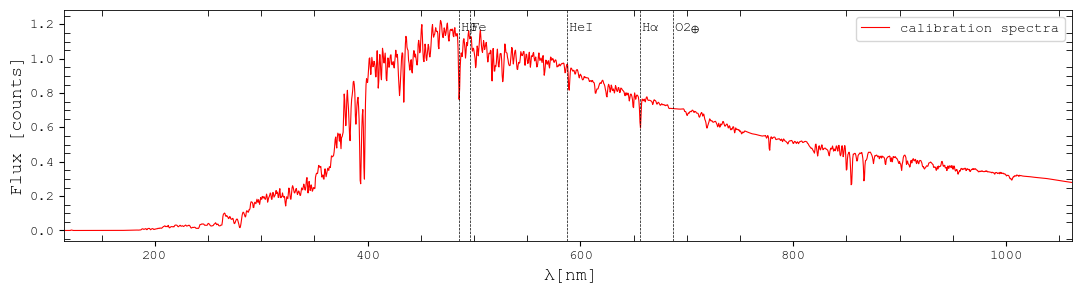

In [24]:
plot_spectra(wavelength, pcygni_extracted, 'P Cygni')
plot_spectra(wavelength, sadr_extracted, 'Sadr', color = 'mediumvioletred')
plot_spectra(cal_wave, cal_flux, 'calibration spectra', color = 'r')

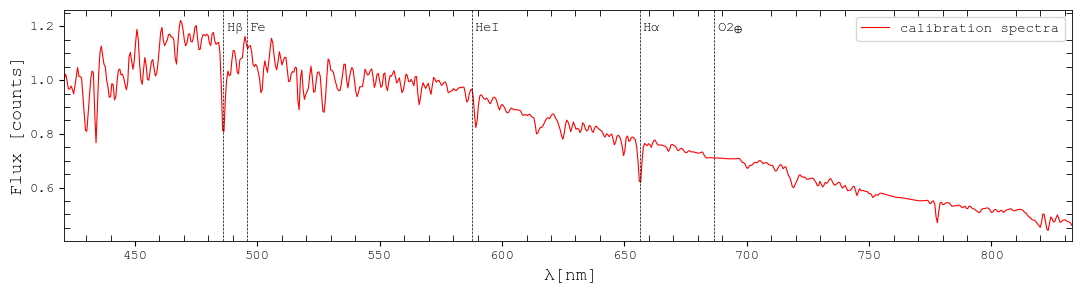

In [25]:
cal_flux_interp = np.interp(wavelength, cal_wave, cal_flux)
plot_spectra(wavelength, cal_flux_interp, 'calibration spectra', color = 'r')

In [19]:
irc = sadr_extracted / cal_flux_interp
irc_norm = irc/np.mean(irc)
coefficients = np.polyfit(wavelength, irc_norm, 4)
continuum_model = np.poly1d(coefficients)

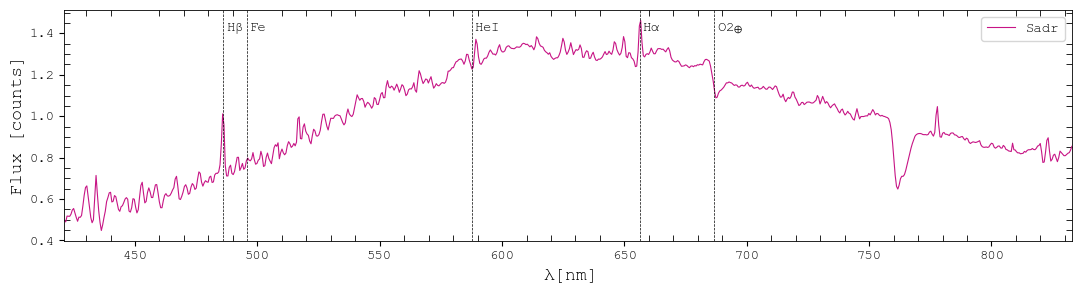

In [20]:
plot_spectra(wavelength, irc_norm, 'Sadr', color = 'mediumvioletred')

In [21]:
cal_pcyg_flux = pcygni_extracted/continuum_model(wavelength)
cal_sadr_flux = sadr_extracted/continuum_model(wavelength)

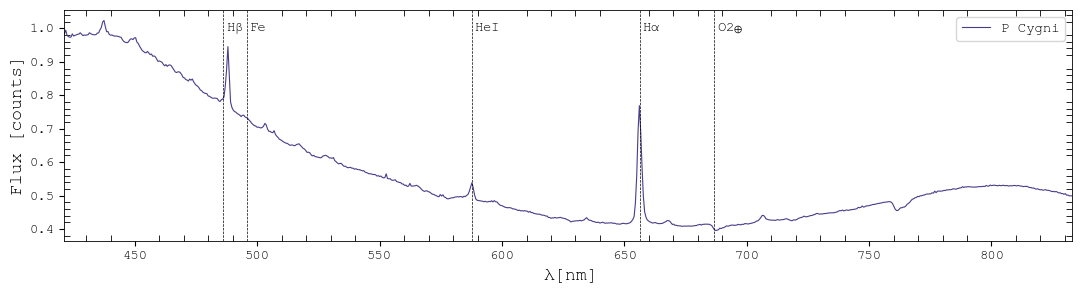

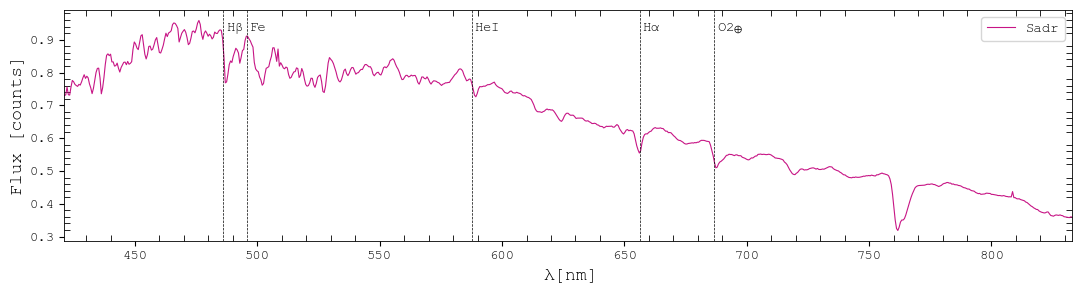

In [22]:
plot_spectra(wavelength, cal_pcyg_flux, 'P Cygni')
plot_spectra(wavelength, cal_sadr_flux, 'Sadr', color = 'mediumvioletred')

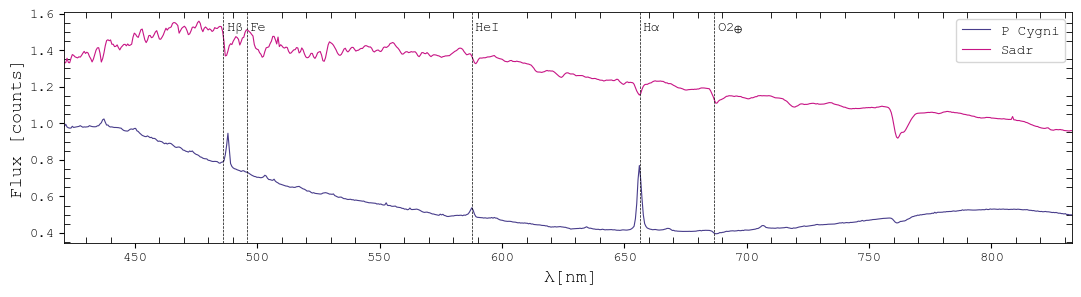

In [23]:
fig, ax = plt.subplots(figsize = (13, 3))
plt.rcParams['font.family'] = 'courier new'
plt.rcParams['mathtext.default'] = 'regular'
ax.minorticks_on()
ax.tick_params(which = 'minor', length = 4, direction = 'in', top = True, right = True)
plt.rcParams['axes.linewidth'] = 0.6

plt.plot(wavelength, cal_pcyg_flux, lw = 0.8, c = 'darkslateblue', label = 'P Cygni')
plt.plot(wavelength, cal_sadr_flux+0.6, lw = 0.8, c = 'mediumvioletred', label = 'Sadr')
padding = 0.08 * (np.max(cal_pcyg_flux) - np.min(cal_pcyg_flux))
ymin = np.min(cal_pcyg_flux) - padding
ymax = np.max(cal_sadr_flux+0.6) + padding

plt.vlines(486.13, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(487.13, ymax-2*padding, r'$H\beta$')
plt.vlines(495.8, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(496.8, ymax-2*padding, 'Fe')
plt.vlines(587.56, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(588.56, ymax-2*padding, r'$He I$')
plt.vlines(656.28, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(657.28, ymax-2*padding, r'$H\alpha$')
plt.vlines(686.7, ymin, ymax, lw = 0.5, color = 'k', ls = '--')
plt.text(687.7, ymax-2*padding, r'$O2_{\oplus}$')

plt.xlim(wavelength[0], wavelength[-1])
plt.ylim(ymin, ymax)
plt.xlabel('$\lambda [nm]$', size = 13)
plt.ylabel('Flux [counts]', size = 13)
plt.legend()
plt.savefig('PCygni_Sadr_spectra.png', format = 'png')
plt.show()